# 3 Recognising patterns on the move

To be really useful a robot needs to recognise things as it goes along, or ‘on the fly’. In this notebook, you will train a neural network to use a simple MLP classifier to try to identify different shapes on the background. The training samples themselves, images *and* training labels, will be captured by the robot from the simulator background.

We will use the two light sensors to collect the data used to train the network:

- one light sensor will capture the shape image data;
- one light sensor will capture the training class data.

To begin with we will contrive things somewhat to collect the data at specific locations on the background. But then you will explore how we can collect images as the robot moves more naturally within the environment.

*There is quite a lot of provided code in this notebook. You are not necessarily expected to be able to create this sort of code yourself. Instead, try to focus on the process of how various tasks are broken down into smaller discrete steps, as well as how small code fragments can be combined to create "higher level" functions that perform ever more powerful tasks.*

Before continuing, ensure the simulator is loaded and available:

In [1]:
from nbev3devsim.load_nbev3devwidget import roboSim, eds
%load_ext nbev3devsim

<IPython.core.display.Javascript object>

Ev3DevWidget(status='deferring flush until render')

The background image *Simple_Shapes* contains several shapes arranged in a line, including a square, a circle, four equilateral triangles (arrow heads) with different orientations, a diamond and a rectangle.

Just below each shape is a grey square, whose fill colour is used to distinguish between the different shapes.

In [2]:
%sim_magic -b Simple_Shapes -x 600 -y 700

### 3.1 Evaluating the possible training data

In this initial training pass, we will check whether the robot can clearly observe the potential training pairs. Each training pair consists of the actual shape image as well as a solid grey square, where the grey colour is use to represent one of eight (8) different training classes.

The left light sensor will be used to sample the shape image data and the right light sensor will be used to collect the simpler grey classification group pattern.

As we are going to be pulling data into the notebook Python environment from the simulator, ensure the local notebook datalog is cleared:

In [3]:
roboSim.clear_datalog()

The *Simple_Shapes* background we are using in this notebook contains several small regular shapes, with label encoding patterns alongside.

The *x* and *y* locations for sampling the eight different images, along with a designator for each shape, as are follows:

- 200 700 square
- 380 700 circle
- 360 700 equitri1
- 440 700 equitri2
- 520 700 equitri3
- 600 700 equitri4
- 680 700 rect
- 760 700 diamond1

We can now start to collect image data from the robot's light sensors. The `-R` switch runs the program once it has been downloaded to the simulator:

If we print the message `"image_data both"` we can collect data from both the left and the right light sensors at the same time.

In [9]:
%%sim_magic_preloaded -b Simple_Shapes -AR -x 760 -y 700 -O

#Sample the light sensor reading
sensor_value = colorLeft.reflected_light_intensity

# This is essentially a command invocation
# not just a print statement!
print("image_data both")

We can preview the collected image data in the usual way:

In [49]:
roboSim.image_data()

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
1,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
2,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
3,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
4,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
5,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
6,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
7,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
8,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
9,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1


We can also collect consecutive rows of data from the dataframe and decode them as left and right images:

(None, None)

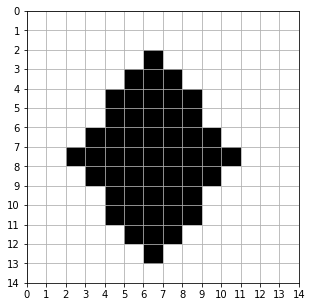

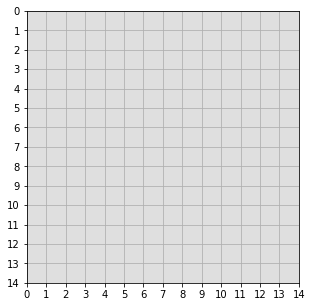

In [14]:
from nn_tools.sensor_data import get_sensor_image_pair
from nn_tools.sensor_data import zoom_img

pair_index = -1

left_img, right_img = get_sensor_image_pair(roboSim.image_data(),
                                            pair_index)
zoom_img(left_img), zoom_img(right_img)

If you don't see a figure image displayed, check that the robot is placed over a figure by reviewing the sensor array display in the simulator. If the image is there, rerun the previous code cell to see if the data is now available. If it isn't, rerun the data collecting magic cell, wait a view seconds, and then try to view the zoomed image display.

We can run the previously downloaded program again from a simple line magic that situates the robot at a specific location and then runs the program to collect the sensor data.

In [7]:
_x = 280

%sim_magic -x $_x -y 700 -RAH

### 3.1.1 Investigating the training data samples

Let's start by seeing if we can collect image data samples for each of the shapes.

In [54]:
from tqdm.notebook import trange
from nbev3devsim.load_nbev3devwidget import tqdma

import time

# Clear the datalog to give us a fresh start
roboSim.clear_datalog()

# x-coordinate for centreline of first shape
_x_init = 200

# Distance between shapes
_x_gap = 80

# Number of shapes
_n_shapes = 8

# y-coordinate for centreline of shapes
_y = 700

# Load in the required background
%sim_magic -b Simple_Shapes

# Generate x coordinate for each shape in turn
for _x in trange(_x_init, _x_init+(_n_shapes*_x_gap), _x_gap):
    
    # Jump to shape and run program to collect data
    %sim_magic -x $_x -y $_y -R
    
    # Wait a short period to allow time for
    # the program to run and capture the sensor data,
    # and for the data to be passed from the simulator
    # to the notebook Python environment
    time.sleep(1)


We should now be able to access multiple image samples via `roboSim.image_data()`, which returns a dataframe containing as many rows as images we scanned:

In [55]:
image_data_df = roboSim.image_data()
image_data_df

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
1,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
2,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
3,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
4,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
5,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
6,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
7,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
8,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
9,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1


The original sensor data is collected as three channel RGB data. By default, the `get_sensor_image_pair()` function, which extracts a pair of consecutive images from the datalog, converts these to greyscale images:

(None, None)

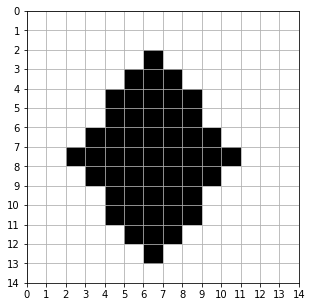

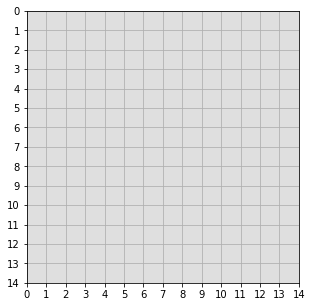

In [56]:
from nn_tools.sensor_data import get_sensor_image_pair

pair_index = -1

left_img, right_img = get_sensor_image_pair(roboSim.image_data(),
                                            pair_index)

zoom_img(left_img), zoom_img(right_img)

We can also filter the dataframe to give us a dataframe containing just the data grabbed from the left hand image sensor:

In [57]:
_df = roboSim.image_data()

# The mechanics behind how this line of code
# works are beyond the scope of this module.
# In short, we identify the rows where the
# "side" column value is equal to "left"
# and select just those rows.
left_images_df = _df[_df['side']=='left']
left_images_df

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
2,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
4,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
6,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
8,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
10,left,"245,226,225,245,226,225,245,226,225,245,226,22...",2
12,left,"245,226,225,245,226,225,245,226,225,245,226,22...",2
14,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1


### 3.1.2 Activity — Using bounding box sizes as a feature for distinguishing between shapes

When we trained a neural network to recognise shape data, we use the dimensions of a bounding box drawn around the fruit as the input features to our network.

Will the bounding box approach used there also allow us to distinguish between the shape images?

Run the following code cell to convert the raw data associated with an image to a data frame, and then prune the rows and columns the edges that only contain white space.

The dimensions of the dataframe, which is to say, the `.shape` of the dataframe, given as the 2-tuple `(rows, columns)`, corresponds to the bounding box of the shape. 

In [58]:
from nn_tools.sensor_data import generate_image, df_from_image, trim_image
from nn_tools.sensor_data import sensor_image_focus

index = -1

# The sensor_image_focus function crops
# to the central focal area of the image array
left_img = sensor_image_focus(generate_image(left_images_df, index))

trimmed_df = trim_image( df_from_image(left_img, show=False), reindex=True)

# dataframe shape
trimmed_df.shape

,0,1,2,3,4,5,6,7,8
0,255,255,255,255,0,255,255,255,255
1,255,255,255,0,0,0,255,255,255
2,255,255,0,0,0,0,0,255,255
3,255,255,0,0,0,0,0,255,255
4,255,0,0,0,0,0,0,0,255
5,0,0,0,0,0,0,0,0,0
6,255,0,0,0,0,0,0,0,255
7,255,255,0,0,0,0,0,255,255
8,255,255,0,0,0,0,0,255,255
9,255,255,255,0,0,0,255,255,255


(11, 9)

Using the above code, or otherwise, find the shape of the bounding box for each shape as captured in the `roboSim.image_data` list.

You may find it useful to use the provided code as the basis of a simple function that will:

- take the index number for a particular image data scan;
- generate the image;
- find the size of the bounding box.

Then you can iterate through all the rows in the `left_images_df` dataset, generate the corresponding image and its bounding box dimensions, and then display the image and the dimensions.

*Hint: you can use a `for` loop defined as `for i in range(len(left_images_df)):` to iterate through each row of the data frame and generate an appropriate index number, `i`, for each row.*

Based on the shape dimensions alone, can you distinguish between the shapes?

In [59]:
# Your code here

*Record your observations here, identifying the bounding box dimensions for each shape (square, circle, equitri1, equitri2, equitri3, equitri4, rect, diamond1). Are the shapes distinguishable from their bounding box sizes?*

#### Example solution

*Click the arrow in the sidebar or run this cell to reveal an example solution.*

Let's start by creating a simple function inspired by the supplied code that will display an image and its bounding box dimensions:

In [60]:
def find_bounding_box(index):
    """Find bounding box for a shape in an image."""
    img = sensor_image_focus(generate_image(left_images_df, index))
    trimmed_df = trim_image( df_from_image(img, show=False), show=False, reindex=True)

    # Show image and shape
    display(img, trimmed_df.shape)

find_bounding_box(0)

(11, 11)

We can then call this function by iterating through each image data record in the `roboSim.image_data` dataset:

In [61]:
for i in range(len(left_images_df)):
    find_bounding_box(i)

(11, 11)

(11, 11)

(11, 9)

(11, 9)

(9, 11)

(10, 11)

(6, 11)

(11, 9)

Inspecting the results from my run (yours may be slightly different), several of the shapes appear to share the same bounding box dimensions:

- the square, circle/octagon and upright triangle all have bounding box dimensions `(11, 11)`;
- the left and right facing triangles and the diamond have the same dimensions (`(11, 9)`).

The rectangle is clearly separated from the other shapes on the basis of its bounding box dimensions, but the other shapes all have dimensions that may be hard to distinguish between.

One other thing to notice in passing is that at least one of the dimensions in each case is equal to 11.

### 3.1.3 Decoding the training label image

The grey filled squares alongside the shape images are used to encode a label describing the associated shape.

The shape names and classes are defined as follows in the order they appear going from left to right along the test track:

In [62]:
# Define the classes
shapemap = {'square': 0,
            'circle': 1,
            'equitri1': 2,
            'equitri2': 3,
            'equitri3': 4,
            'equitri4': 5,
            'rect': 6,
            'diamond1': 7
           }

The grey levels are determined by the following algorithm, in which we use the numerical class values to derive the greyscale value:

In [63]:
from numpy import nan

greymap = {nan: 'unknown'}

# Generate greyscale value
for shape in shapemap:
    key = int(shapemap[shape] * 255/len(shapemap))
    greymap[key] = shape
    
greymap

{nan: 'unknown',
 0: 'square',
 31: 'circle',
 63: 'equitri1',
 95: 'equitri2',
 127: 'equitri3',
 159: 'equitri4',
 191: 'rect',
 223: 'diamond1'}

Let's see if we can decode the labels from the solid grey squares.

To to try to make sure we are using actual shape image data, we can can identify images in our training set if *all* the pixels in the right hand image are the same value.

In [64]:
left_img, right_img = get_sensor_image_pair(roboSim.image_data(), -1)

# Generate a set of distinct pixel values
# from the right hand image.
# Return True if there is only one value
# in the set. That is, all the values are the same.
len(set(right_img.getdata())) == 1

True

The following function can be used to generate a greyscale image from a row of the dataframe, find the median pixel value within that image, and then try to decode it. We also return a flag (`uniform`) that identifies if the all the pixels in the right hand encoded label image are the same.

In [65]:
def decode_shape(img):
    """Decode the shape from the greyscale image."""
    # Get the image greyscale pixel data
    # The pandas Series is a convenient representation
    image_pixels = pd.Series(list(img.getdata()))
    
    # Find the median pixel value
    pixels_median = int(image_pixels.median())
    
    shape = None
    code= None
    #uniform = len(set(img.getdata())) == 1
    # There is often more than one way to do it!
    # The following makes use of Series.unique()
    # which identifies the distinct values in a Series
    uniform = len(image_pixels.unique()) == 1
    
    if pixels_median in greymap:
        shape = greymap[pixels_median]
        code = shapemap[greymap[pixels_median]]
        
    return (pixels_median, shape, code, uniform)

We can apply that function to each row of the dataframe by iterating over pairs of rows:

In [66]:
import pandas as pd

shapes = []

# The number of row pairs is half the number of rows
num_pairs = int(len(roboSim.image_data())/2)

for i in range(num_pairs):
    
    # Rretrieve a pair of images 
    # from the datalog dataframe:
    left_img, right_img = get_sensor_image_pair(roboSim.image_data(), i)
    
    #Decode the label image
    (grey, shape, code, uniform) = decode_shape(right_img)
    
    # Add the label to a list of labels found so far
    shapes.append(shape)

    # Display the result of decoding
    # the median pixel value
    print(f"Grey: {grey}; shape: {shape}; code: {code}; uniform: {uniform}")

Grey: 0; shape: square; code: 0; uniform: True
Grey: 31; shape: circle; code: 1; uniform: True
Grey: 63; shape: equitri1; code: 2; uniform: True
Grey: 95; shape: equitri2; code: 3; uniform: True
Grey: 127; shape: equitri3; code: 4; uniform: True
Grey: 159; shape: equitri4; code: 5; uniform: True
Grey: 191; shape: rect; code: 6; uniform: True
Grey: 223; shape: diamond1; code: 7; uniform: True


We can also use the `decode_shape()` function as part of another function that will return a shape training image and it's associated label from a left and right sensor row pair in the datalog dataframe:

In [67]:
def get_training_data(raw_df, pair_index):
    """Get training image and label from raw data frame."""
    
    # Get the left and right images
    # at specified pair index
    left_img, right_img = get_sensor_image_pair(raw_df,
                                            pair_index)
    
    (grey, shape, code, uniform) = decode_shape(right_img)
    return (shape, code, uniform, left_img)

To use the `get_training_data()` function, we pass it the datalog dataframe and the index of the desired image pair:

diamond1 7 True


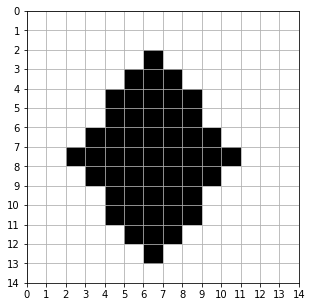

In [71]:
pair_index = -1
    
response = get_training_data(roboSim.image_data(), pair_index)
(shape, code, uniform, training_img) = response

print(shape, code, uniform)
zoom_img(training_img)

In summary, we can now:
    
- grab the greyscale training image;
- find the median greyscale value;
- try to decode that value to a shape label / code;
- return the shape label and code associated with that greyscale image, along with an indicator of whether the image is in view via the `uniform` training image array flag;
- label the corresponding shape image with the appropriate label.

## 3.2 Real time data collection

In this section, you will start to explore how to collect data in real time as the robot drives over the images, rather than being teleported directly on top of them.

### 3.2.1 Identifying when the robot is over a pattern in real time

If we want to collect data from the robot as it drives slowly over the images we need to be able to identify when it is passing over the images and trigger the image sampling.

The following program will slow drive over the test patterns, logging the reflected light sensor values every so often.

From the traces on the simulator chart, can you identify   when the robot passes over the images?

*Record your observations here.*

In [16]:
%%sim_magic_preloaded -b Simple_Shapes -x 100 -y 700 -OAc

# Start driving forwards slowly
tank_drive.on(SpeedPercent(10), SpeedPercent(10))

count = 1

# Drive forward no further than a specified distance
while int(tank_drive.left_motor.position)<1500:
    
    left_light = colorLeft.reflected_light_intensity_pc
    right_light = colorRight.reflected_light_intensity_pc
    
    # report every fifth pass of the loop
    if not (count % 5):
        print('Light_left: ' + str(left_light))
        print('Light_right: ' + str(right_light))

    count = count + 1

*Based on your observations, describe a strategy you might use to capture image sample data when the test images are largely in view.*

### 3.2.2 Challenge — capturing image data in real time (optional)

Using your observations regarding the reflected light sensor values as the robot crosses the images, or otherwise, write a program to collect image data from the simulator in real time as the robot drives over them.

*Describe your program strategy and record your program design notes here.*

In [17]:
# Your code here

### 3.2.3 Capturing image data in real time

By observation of the reflected light sensor data in the chart, the robot appears to be over the a shape, as the reflected light sensor values drop below about 90%.

From the chart, we might also notice that the training label image (encoded as the solid grey square presented to the right hand sensor) gives distinct readings for each shape.

We can therefore use a drop in the reflected light sensor value to trigger the collection of the image data.

First, let's clear the datalog:

In [18]:
# Clear the datalog to give us a fresh start
roboSim.clear_datalog()

Now we can write a program to drive the robot forwards slowly and collect the image data when it is over an image:

In [20]:
%%sim_magic_preloaded -b Simple_Shapes -x 100 -y 700 -OAR

# Start driving forwards slowly
tank_drive.on(SpeedPercent(10), SpeedPercent(10))

# Drive forward no futher than a specified distance
while int(tank_drive.left_motor.position)<1500:
    
    # Sample the right sensor
    sample = colorRight.reflected_light_intensity_pc
    # If we seem to be over a test label,
    # grab the image data into the datalof
    if sample < 90:
        print("image_data both")

If we review the the images in the datalog, we should see they all contain a fragment at least of the image data:

(None, None)

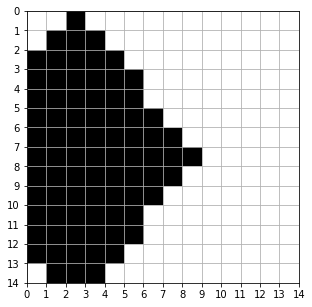

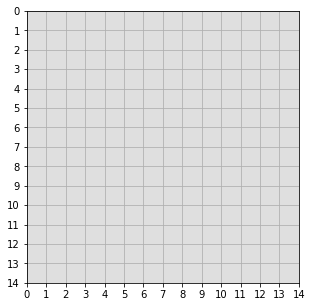

In [21]:
pair_index = -1

left_img, right_img = get_sensor_image_pair(roboSim.image_data(),
                                            pair_index)

zoom_img(left_img), zoom_img(right_img)

In [21]:
roboSim.image_data()

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",50
1,right,"245,226,225,245,226,225,245,226,225,245,226,22...",50
2,left,"245,226,225,245,226,225,245,226,225,245,226,22...",50
3,right,"245,226,225,245,226,225,245,226,225,245,226,22...",50
4,left,"245,226,225,245,226,225,245,226,225,245,226,22...",50
...,...,...,...
393,right,"245,226,225,245,226,225,245,226,225,245,226,22...",389
394,left,"245,226,225,245,226,225,245,226,225,245,226,22...",389
395,right,"245,226,225,245,226,225,245,226,225,245,226,22...",389
396,left,"245,226,225,245,226,225,245,226,225,245,226,22...",390


We are now in a position to try to use the data collected by traveling over the test track to train the neural network.

## TO DO - show the effect of the uniform flag

## 3.2 Training an MLP to recognise the patterns

In an earlier activity, we discovered that the bounding box method we used to distinguish fruits did not provide a set of features that we could use to distinguish the different shapes.

So let's just use a "naive" training approach and just train the network on the 14 x 14 pixels in the centre of each sensor image array.

As well as using the collected data, we can also use derived "jiggled" images as part of the training set.

## 3.3 Testing the network with collected data

Let's collect some data again by driving the robot over the test track as we did before.

Now let's grab the shape image data and use that as a test set presented to the neural network.




What happens if you test the network using data collected by running the robot over the test track at a different speed, or with the 

In [54]:
scanned_image_data_df = roboSim.image_data()
scanned_image_data_df

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
1,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
2,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
3,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
4,left,"245,226,225,245,226,225,245,226,225,245,226,22...",2
...,...,...,...
533,right,"245,226,225,245,226,225,245,226,225,245,226,22...",397
534,left,"245,226,225,245,226,225,245,226,225,245,226,22...",397
535,right,"245,226,225,245,226,225,245,226,225,245,226,22...",397
536,left,"245,226,225,245,226,225,245,226,225,245,226,22...",398


In [ ]:
image_data_df = roboSim.image_data()
image_data_df[-2:]

In [ ]:
# training - not much data but train on it

In [ ]:
# testing -static

In [ ]:
# testing - dynamic?

The `nn_tools.sensor_data.get_sensor_image_pair` takes the original log data and grabs left and right sensor values based on the index of the left sensor value. (If no index is provided, the last two readings in the data log are inspected.)

The resulting images are converted to greyscale images and cropped to the central focus area of each sensor.

In [ ]:
from nn_tools.sensor_data import get_sensor_image_pair

# The sample we want from the logged image data
_index = 10

left_img, right_img = get_sensor_image_pair(roboSim.image_data, _index)

display(left_img, right_img)


The right sensor gives a uniform greyscale value. We can take the most common value (the *mode*) and use that to identify the class of the image.

In [ ]:
import numpy as np

np.mode(right_img.getdata())

We can use the following mapping to decode the actual shape from the training signal:

In [ ]:
shape_map = {'shape': value}

Generate training patterns:

In [ ]:
# training set

In [ ]:
# train netwrok

In [ ]:
# test network

In [ ]:
# train on random images or random test track...

In [ ]:
%%sim_magic_preloaded -b Simple_Shapes -x 700 -y 716 -O
tank_drive.on(SpeedPercent(10), SpeedPercent(10))
while True:
    sample = colorRight.reflected_light_intensity_pc
    #print(sample)
    if sample>12 and sample<13:
        print('here...')

Can we identify when we have seen a grey training class square?

In [ ]:
# function to count what percentage of classificaiton group image pixels
# are non-background; if this is 0 (or < threshold) decide we have seen a thing
# and take the most common pixel value as the discriminator

![figure ../tm129-19J-images/tm129_rob_p9_f010.jpg](../tm129-19J-images/tm129_rob_p9_f010.jpg)

Figure 4.2 Two sets of scan lines of different lengths

A diagram showing sets of scan lines on a rectangle and diamond block. There are about four scan lines over the rectangle, appearing as arcs across it, all of equal length. The diamond has about six scan lines which are short at the point of the diamond, becomes much longer across the middle, and then become shorter towards the end of the diamond.

My data for the shapes in Figure 4.1 are given in Table 4.1.
<table xmlns:str="http://exslt.org/strings">
<caption>Table 4.1 Scan data for shapes 1–4</caption>
<tbody>
<tr>
<th>
Shape
</th>
<th></th>
<th>
First circuit
</th>
<th>
Second circuit
</th>
<th>
Third circuit
</th>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">1</td>
<td class="highlight_" rowspan="" colspan=""> ![narrow rectangle](../tm129-19J-images/tm129_rob_p9_f011.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
7, 12, 13, 12, 13, 20, 0, 3
</td>
<td class="highlight_" rowspan="" colspan="">
9, 13, 14, 13, 12, 12, 3, 3
</td>
<td class="highlight_" rowspan="" colspan="">
8, 12, 12, 12, 12, 12, 3, 3
</td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">2</td>
<td class="highlight_" rowspan="" colspan=""> ![diamond](../tm129-19J-images/tm129_rob_p9_f012.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
4, 7, 11, 14, 17, 20, 14, 9
</td>
<td class="highlight_" rowspan="" colspan="">
3, 6, 8, 13, 16, 19, 13, 8
</td>
<td class="highlight_" rowspan="" colspan="">
3, 7, 10, 13, 16, 19, 13, 9
</td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">3</td>
<td class="highlight_" rowspan="" colspan=""> ![broad rectangle](../tm129-19J-images/tm129_rob_p9_f013.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
10, 20, 19, 19, 20, 3, 3, 3
</td>
<td class="highlight_" rowspan="" colspan="">
8, 17, 18, 17, 17, 3, 3, 3
</td>
<td class="highlight_" rowspan="" colspan="">
10, 17, 17, 16, 17, 3, 3, 3
</td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">4</td>
<td class="highlight_" rowspan="" colspan=""> ![circle](../tm129-19J-images/tm129_rob_p9_f014.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
5, 13, 19, 22, 21, 13, 3, 3
</td>
<td class="highlight_" rowspan="" colspan="">
6, 12, 17, 20, 18, 4, 3, 3
</td>
<td class="highlight_" rowspan="" colspan="">
4, 11, 17, 19, 19, 11, 3, 3
</td>
</tr>
</tbody>
</table>

Simon uses a neural network that I trained using these data. Once it has collected the scan data, it goes through the protocol in Figure 3.2, to receive the class code. When I trained the network I gave it class codes 1, 2, 3 and 4 for the shapes, using the numbering in Figure 4.1.

When the network sends back the recognition codes, it uses the ASCII values shown in Table 3.1: 49 (for 1), 50 (for 2), 51 (for 3), and 52 (for 4).

## 4.1 Activity — collecting scan data

Figure 4.3 shows a new set of blocks. In this activity you will collect data that will be used to train a neural network. Open the `Get_block_data` program. When you run this program it detects a shape and logs data for it.

![figure ../tm129-19J-images/tm129_rob_p9_f016.jpg](../tm129-19J-images/tm129_rob_p9_f016.jpg)

Figure 4.3 A set of blocks ready for collecting scan data

The background image for ‘Get block data’. This is a red track as before but with different black blocks as follows: 

1.  triangle (point towards Simon)

2.  very narrow rectangle, about twice the width of the track

3.  oval

4.  black line no wider than the track.

Position Simon as shown in Figure 4.3 and run the program. When Simon has moved across shape number 5 it will stop. Open the Data log window.

Click on the Upload  ![inlinefigure ../tm129-19J-images/tm129_rob_p9_f018.jpg](../tm129-19J-images/tm129_rob_p9_f018.jpg)  toolbar button or choose `Connect | Upload data log` to upload the data log<div xmlns:str="http://exslt.org/strings" style="background:lightblue"><p>Keyboard: Alt, C, U</p></div> and then click on the `Data` tab so that you can see the logged data, as shown in Figure 4.4.

![figure ../tm129-19J-images/tm129_rob_p9_f019.png](../tm129-19J-images/tm129_rob_p9_f019.png)

Figure 4.4 Logged data for shape number 5

The Data log table view with the following values: 
<table xmlns:str="http://exslt.org/strings">
<caption></caption>
<tbody>
<tr>
<td class="highlight_" rowspan="" colspan=""> n </td>
<td class="highlight_" rowspan="" colspan=""> value </td>
<td class="highlight_" rowspan="" colspan=""> source </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 1 </td>
<td class="highlight_" rowspan="" colspan=""> 2 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 2 </td>
<td class="highlight_" rowspan="" colspan=""> 7 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 3 </td>
<td class="highlight_" rowspan="" colspan=""> 9 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 4 </td>
<td class="highlight_" rowspan="" colspan=""> 13 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 5 </td>
<td class="highlight_" rowspan="" colspan=""> 16 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 6 </td>
<td class="highlight_" rowspan="" colspan=""> 21 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 7 </td>
<td class="highlight_" rowspan="" colspan=""> 25 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 8 </td>
<td class="highlight_" rowspan="" colspan=""> 6 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 9 </td>
<td class="highlight_" rowspan="" colspan=""> 0 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 10 </td>
<td class="highlight_" rowspan="" colspan=""> 3 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 11 </td>
<td class="highlight_" rowspan="" colspan=""> 3 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 12 </td>
<td class="highlight_" rowspan="" colspan=""> 3 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 13 </td>
<td class="highlight_" rowspan="" colspan=""> 3 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 14 </td>
<td class="highlight_" rowspan="" colspan=""> 3 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan=""> 15 </td>
<td class="highlight_" rowspan="" colspan=""> 23 </td>
<td class="highlight_" rowspan="" colspan=""> unknown </td>
</tr>
</tbody>
</table>

The program usually logs more than the eight measurements needed for the neural network. Small shapes may not require eight measurements, in which case the last measurements recorded are about 3 – corresponding to the red line.

Position Simon in front of each of the remaining three shapes to log data for them. I have done the first set of measurements for each shape in Table 4.2. Complete the table with two more sets of measurements for each shape.
<table xmlns:str="http://exslt.org/strings">
<caption>Table 4.2 Scan data for shapes 5–8</caption>
<tbody>
<tr>
<th>
Shape
</th>
<th></th>
<th>
First circuit
</th>
<th>
Second circuit
</th>
<th>
Third circuit
</th>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">5</td>
<td class="highlight_" rowspan="" colspan=""> ![triangle](../tm129-19J-images/tm129_rob_p9_f020.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
2, 7, 9, 13, 16, 21, 25, 5
</td>
<td class="highlight_" rowspan="" colspan=""></td>
<td class="highlight_" rowspan="" colspan=""></td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">6</td>
<td class="highlight_" rowspan="" colspan=""> ![narrow rectangle](../tm129-19J-images/tm129_rob_p9_f021.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
4, 6, 5, 5, 5, 5, 5, 5
</td>
<td class="highlight_" rowspan="" colspan=""></td>
<td class="highlight_" rowspan="" colspan=""></td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">7</td>
<td class="highlight_" rowspan="" colspan=""> ![oval](../tm129-19J-images/tm129_rob_p9_f022.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
4, 11, 16, 21, 23, 23, 21, 13
</td>
<td class="highlight_" rowspan="" colspan=""></td>
<td class="highlight_" rowspan="" colspan=""></td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">8</td>
<td class="highlight_" rowspan="" colspan=""> ![line](../tm129-19J-images/tm129_rob_p9_f023.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
4, 3, 4, 3, 3, 3, 3, 2
</td>
<td class="highlight_" rowspan="" colspan=""></td>
<td class="highlight_" rowspan="" colspan=""></td>
</tr>
</tbody>
</table>

In [ ]:
import pandas as pd

df = pd.DataFrame([['Pear', [5.2, 3.1]], ['Pear', [6.3, 2.4]],
                   ['Pear', [6.7, 1.8]], ['Pear', [5.3, 2.9]],
                   ['Banana', [8.5, 1.9]], ['Banana', [8.3, 1.6]],
                   ['Banana', [9.7, 2.0]], ['Banana', [7.5, 1.7]],
                   ['Strawberry', [2.1, 1.4]], ['Strawberry', [2.8, 1.8]],
                   ['Strawberry', [2.0, 1.8]], ['Strawberry', [2.2, 2.0]],
                   ['Orange', [4.7, 4.5]], ['Orange', [4.6, 4.2]],
                   ['Orange', [4.6, 4.1]], ['Orange', [4.0, 3.7]]
                  ],
                 columns = ['Fruit', 'Input'])

#Preview the first six rows
df.head(6)

In [ ]:
from sklearn.neural_network import MLPClassifier

fruit = MLPClassifier(hidden_layer_sizes=(6, 6), max_iter=20)

In [ ]:
# Fit the model
fruit.fit(df['Input'].to_list(), df['Fruit'])

#Check the prediction for each input
predictions = fruit.predict(df['Input'].to_list())
predictions

In [ ]:
from sklearn.metrics import classification_report

# The zero_division parameter suppresses a divide by zero warning when using zeroed parameters
print(classification_report(df['Fruit'], predictions, zero_division=False))

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(df['Fruit'], predictions))

In [ ]:
from ipywidgets import interact

fruit = None

@interact(iterations=(100, 3000, 100), h1=(0, 10, 1), h2=(0, 10, 1))
def trainer(iterations=2000, h1=6, h2=6):
    global fruit
    fruit = MLPClassifier(hidden_layer_sizes=(h1, h2), max_iter=iterations)
    
    # Fit the model
    fruit.fit(df['Input'].to_list(), df['Fruit'])
    
    #Check the prediction for each input
    predictions = fruit.predict(df['Input'].to_list())

    print(classification_report(df['Fruit'], predictions))
    print(confusion_matrix(df['Fruit'], predictions))

## 4.2 Activity — training a neural network with the shape data

Start the `Neural network editor`. Click on `File | New Network`. Clear the `For existing data` check box. Change the number of inputs to 8, the number of outputs to 8, and set the number of neurons for the `1st hidden` and `2nd hidden` layers to 10 each, as shown in Figure 4.5(a). Then click `OK`. A warning box will be shown (Figure 4.5(b)); click `OK` to confirm that you are replacing previous training data.

![figure ../tm129-19J-images/tm129_rob_p8_f04_05a.png](../tm129-19J-images/tm129_rob_p8_f04_05a.png)

Figure 4.5 (a) `New Network` dialog box; (b) warning box

(a) A screen dump of the New network dialog. This has two panels and OK and Cancel buttons. The top panel has a prompt: ‘Number of nodes in each layer (0 if layer does not exist)’. This is followed by four labelled input fields: ‘Output layer’, ‘2nd hidden’, ‘1st hidden’ and ‘Input layer’. The lower panel has check boxes as follows: ‘For existing data’, ‘Scanner data’ and subsidiary to that ‘Use transitions’. 

(b) A warning alert box which reads: ‘The current training data will be removed! Do you want to proceed?’ followed by OK and Cancel buttons.

Use the outputs and labels in Table 4.3 together with the input data from Table 4.2 for your 12 data items. Remember to include spaces, not commas, when entering the data.
<table xmlns:str="http://exslt.org/strings">
<caption>Table 4.3 Outputs for shapes 5–8</caption>
<tbody>
<tr>
<th>
Shape
</th>
<th></th>
<th>
Outputs
</th>
<th>
Item label
</th>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">5</td>
<td class="highlight_" rowspan="" colspan=""> ![triangle](../tm129-19J-images/tm129_rob_p9_f020.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
0, 0, 0, 0, 1, 0, 0, 0
</td>
<td class="highlight_" rowspan="" colspan="">
5
</td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">6</td>
<td class="highlight_" rowspan="" colspan=""> ![narrow rectangle](../tm129-19J-images/tm129_rob_p9_f021.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
0, 0, 0, 0, 0, 1, 0, 0
</td>
<td class="highlight_" rowspan="" colspan="">
6
</td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">7</td>
<td class="highlight_" rowspan="" colspan=""> ![oval](../tm129-19J-images/tm129_rob_p9_f022.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
0, 0, 0, 0, 0, 0, 1, 0
</td>
<td class="highlight_" rowspan="" colspan="">
7
</td>
</tr>
<tr>
<td class="highlight_" rowspan="" colspan="">8</td>
<td class="highlight_" rowspan="" colspan=""> ![line](../tm129-19J-images/tm129_rob_p9_f023.jpg) </td>
<td class="highlight_" rowspan="" colspan="">
0, 0, 0, 0, 0, 0, 0, 1
</td>
<td class="highlight_" rowspan="" colspan="">
8
</td>
</tr>
</tbody>
</table>

When you have entered your data, save the network with the name `my_net` in the `week-8` folder by clicking on `File | Save As …`. (The neural network editor will add the extension `nnd` to make the complete filename `my_net.nnd`.)

My data appeared as follows, but yours will be different:

![figure ../tm129-19J-images/tm129_rob_p9_f027.jpg](../tm129-19J-images/tm129_rob_p9_f027.jpg)

Sample training data from the Neural network editor list. 

 Tr 1:     2 7 9 13 16 21 25 5 » 0 0 0 0 1 0 0 0 ‘5’ 

 Tr 2:     4 6 5 5 5 5 5 5 » 0 0 0 0 0 1 0 0 ‘6’ 

 Tr 3:     4 11 16 21 23 23 21 13 » 0 0 0 0 0 0 1 0 ‘7’ 

 Tr 4:     4 3 4 3 3 3 3 2 » 0 0 0 0 0 0 0 1 ‘8’ 

 Tr 5:     2 6 8 11 15 21 24 6 » 0 0 0 0 1 0 0 0 ‘5’ 

 Tr 6:     4 6 5 5 5 5 5 5 » 0 0 0 0 0 1 0 0 ‘6’ 

 Tr 7:     4 12 17 21 23 22 19 3 » 0 0 0 0 0 0 1 0 ‘7’ 

 Tr 8:     2 3 3 3 3 3 3 3 » 0 0 0 0 0 0 0 1 ‘8’ 

 Tr 9:     3 6 9 13 17 21 25 4 » 0 0 0 0 1 0 0 0 ‘5’ 

 Tr 10:   4 6 5 5 5 5 5 5 » 0 0 0 0 0 1 0 0 ‘6’ 

 Tr 11:   3 13 18 22 23 23 19 1 » 0 0 0 0 0 0 1 0 ‘7’ 

 Tr 12:   3 3 3 3 3 3 3 3 » 0 0 0 0 0 0 0 1 ‘8’ 

Click on `Seed and Scale` and then `Cycle Until`. Your network should train, with all the training items correctly classified.

To save your trained neural network, click on `File | Save`. The trained network can now be used to classify new unseen data. This network will be used in the next activity. Make sure it has the name `my_net.nnd`, otherwise the next activity will not work properly.

## 4.3 Activity — running the simon–pc two-agent system

Open the `Classify_my_block_data` program. The configuration for this program assumes that the file `my_net.nnd` which you previously created is in the same folder; that is, `week-8`. The simulation window will show the objects in <a xmlns:str="http://exslt.org/strings" href="">Figure 4.3</a>. Place Simon in front of the triangular object, as shown in Figure 4.3, and run the program.

You should find that Simon scans the objects, stops, sends the data log to the PC, receives back a classification, recognises the object, and says the correct number, or says that the object was not recognised. If you run into problems, you can run the program using my trained neural network by running the `Classify_CT_block_data` program.


## Summary

learn how we can make a more responsive system where the robot explores the world on its own and sends image data back to the notebook, where an agent responds with confident digit identifications back to the robot that announces what it has seen.